In [ ]:
using LazySets
import Plots
using Plots: plot, plot!, text, lens!, bbox
# custom plot shorthands
p(args...; kwargs...) = plot(xlims=(0, 4), ylims=(0, 4), ratio=1, lab="", xlab="x₁", ylab="x₂", args...; kwargs...)
p!(args...; kwargs...) = plot!(lab="", args...; kwargs...);

# Introduction

This notebook is a tutorial to [`LazySets`](https://github.com/JuliaReach/LazySets.jl).

`LazySets` is a Julia library for set computations. Whenever we say **set**, we mean a *set of points* (or *vectors*).

We usually consider two-dimensional points here simply because we can draw them in the plane, but everything generalizes to higher dimensions.

In this section we show some simple motivating examples without explaining the details.

Let us start with three points in $\mathbb{R}^2$: $p_1 = (1, 1)^T, p_2 = (3, 1)^T, p_3 = (2, 3)^T$

In [ ]:
p1 = [1.0, 1.0]
p2 = [3.0, 1.0]
p3 = [2.0, 3.0];

We can wrap these points in `Singleton` sets (sets containing exactly one point) and plot them.

In [ ]:
p([Singleton(p1), Singleton(p2), Singleton(p3)])

Obviously we can do that for many more points. But say that we want to represent infinitely many points. How do we do that? A mathematician would suggest to use *set comprehension*. One goal of `LazySets` is to provide a simple and effective representation of infinite sets in a similar way. Below we give some illustrative examples.

Define the set of all points on the line segment between $p_2$ and $p_3$:

$$\{\lambda \cdot p_2 + (1 - \lambda) \cdot p_3 \in \mathbb{R}^2 \mid \lambda \in [0, 1] \}$$

`LazySets` offers `LineSegment`, which receives the two end points.

In [ ]:
p(LineSegment(p2, p3))

Define the set of all points on the three line segments between $p_1$, $p_2$, and $p_3$:

$$\{\lambda \cdot x + (1 - \lambda) \cdot y \in \mathbb{R}^2 \mid \lambda \in [0, 1], x, y \in \{p_1, p_2, p_3\} \}$$

In [ ]:
p([LineSegment(p2, p3), LineSegment(p1, p3), LineSegment(p1, p2)])

Define the set of all points in the *polygon* spanned by $p_1$, $p_2$, and $p_3$:

$$\{\lambda_1 \cdot p_1 + \lambda_2 \cdot p_2 + \lambda_3 \cdot p_3 \in \mathbb{R}^2 \mid \lambda_1, \lambda_2, \lambda_3 \geq 0, \lambda_1 + \lambda_2 + \lambda_3 = 1 \}$$

`LazySets` offers `VPolygon`, which receives the vertices.

In [ ]:
V = VPolygon([p1, p2, p3])

p(V)
p!([Singleton(p1), Singleton(p2), Singleton(p3)])

All points below the line $x_2 = 3 - x_1$ (which can also be written as $x_1 + x_2 = 3$):

$$\{ (x_1, x_2)^T \in \mathbb{R}^2 \mid x_1 + x_2 \leq 3 \}$$

In [ ]:
H = HalfSpace([1.0, 1.0], 3.0)

p(H)

The intersection of the previous two sets:

$$\{\lambda_1 \cdot p_1 + \lambda_2 \cdot p_2 + \lambda_3 \cdot p_3 \in \mathbb{R}^2 \mid \lambda_1, \lambda_2, \lambda_3 \geq 0, \lambda_1 + \lambda_2 + \lambda_3 = 1 \} \cap \{ (x_1, x_2)^T \in \mathbb{R}^2 \mid x_1 + x_2 \leq 3 \}$$

In [ ]:
p(H, alpha=0.2)
p!(V, alpha=0.2)
p!(intersection(H, V), linestyle=:dash, linewidth=2)

The idea is to have **set primitives** to represent simple sets and to use **set operations** to create more complex sets. We will cover these in the next sections.

---

# Set representation in `LazySets`

The main section of this tutorial covers the representation of sets in the library.

## Closed convex sets

In `LazySets` we only consider **closed sets**.

Informally, a set $X$ is closed if it contains its boundary points. For example, the interval
$$[1, 2] = \{x \in \mathbb{R} \mid 1 \leq x \leq 2\}$$
is closed, unlike the half-open interval
$$(1, 2] = \{x \in \mathbb{R} \mid 1 < x \leq 2\}.$$

Originally, `LazySets` was designed for **convex sets** only. Convex sets form a robust family of sets that enojy nice properties and are mostly efficient to deal with. We shall see this later.

Informally, a set of points $X$ is *convex* if you can pick any two points $x, y \in X$, connect them with a line segment, and then any point $z$ on that line segment is also contained in $X$.

(Meanwhile there is also some limited support for non-convex sets in `LazySets`, but we will not cover those in this tutorial.)

In the following plot, the pentagon and the square are convex, but their union is not.

In [ ]:
P = VPolygon([[2, 3], [3, 2], [2.5, 1], [1.5, 1], [1, 2]])
B = BallInf([3.3, 3.3], 0.5)

p(P)
p!(B)

# line segments between random points
[p!(LineSegment(sample(P), sample(P)), alpha=1) for _ in 1:3]
[p!(LineSegment(sample(B), sample(B)), alpha=1) for _ in 1:3]
p!(LineSegment(sample(P), sample(B)), alpha=1, color=:red, linewidth=3)

The hourglass below is also non-convex.

In [ ]:
p(UnionSet(VPolygon([[0., 4.], [2., 1.9], [4, 4.]]),
           VPolygon([[0., 0.], [2., 2.1], [4, 0.]])))

p!(LineSegment([1.8, 1.5], [2.3, 3.4]), alpha=1, color=:green, linewidth=3)
p!(LineSegment([3, 0.5], [2.5, 2.5]), alpha=1, color=:red, linewidth=3)

## Symbolic representation

Mathematically, a set can be seen as a *membership predicate*. Thisis also easy to implement in basic Julia.

For example, the set of non-positive numbers,

$$\{ x \in \mathbb{R}^n \mid x \leq 0 \},$$

can be represented with the predicate $P(x) = x \leq 0$.

In [ ]:
predP(x) = x <= 0;

In [ ]:
for i in [0, 2, -3]
    println("predP($i) = $(predP(i))")
end

We can even apply common set operations (like *intersection*) to predicates. For example, intersecting the above set with

$$\{ x \in \mathbb{R}^n : |x - 1| \leq 1 \}$$

respectively the predicate $Q(x) = |x - 1| \leq 1$ is achieved by just defining a new predicate $R$ for the conjunction of both predicates.

In [ ]:
predQ(x) = abs(x - 1) <= 1
predR(x) = predP(x) && predQ(x);

In [ ]:
for i in [0, 2, -3]
    println("P($i) = $(predP(i)) \t Q($i) = $(predQ(i)) \t R($i) = $(predR(i))")
end

The downside is that we can only use these predicates for membership queries. But we want to be able to do more complex operations on sets. So we need dedicated structs to represent common kinds of sets.

## Basic sets

We only need a few basic set representations.

### Half-space

The half-space $\{ x \in \mathbb{R}^n \mid a^T x \leq b \}$ is parametric in $a \in \mathbb{R^n}$ and $b \in \mathbb{R}$. Below we construct a half-space for $a = (1, 1)^T$ and $b = 2$. That corresponds to $x_1 + x_2 \leq 2$. 

In [ ]:
p(xlims=(0, 2), ylims=(0, 2))
a = [1.0, 1.0]
b = 2.0

H = HalfSpace(a, b)

p!(H, linewidth=4)

# normal arrow
p!([1.0, 1.5], [1.0, 1.5], linecolor=:red, arrow=:arrow,
   linestyle=:dot, width=4, annotations=(1.15, 1.4, text("a", 20)))

Instead of defining $a$ and $b$, we can alternatively use [`Symbolics`](https://github.com/JuliaSymbolics/Symbolics.jl) to construct a half-space in a way that is sometimes more convenient. For example, the half-space above can be written as
$$\{ (x, y) \in \mathbb{R}^2 \mid x + y \leq 2 \}.$$

In [ ]:
using Symbolics
var = @variables x y
H2 = HalfSpace(x + y ≤ 2, var)

We can let `LazySets` check that these two constructions represent the same set. (In fact, in this case they even use the same set representation.)

In [ ]:
@show isequivalent(H, H2)
println()
@show H
println()
@show H2;

The half-space is the most basic convex set. All other convex sets can be described as an (possibly infinite) intersection of half-spaces. To effectively represent common convex sets, there are many more set representations in `LazySets`. We will look at a few of them below.

### Singleton

The singleton $\{x\}$ contains a single point $x$.

In [ ]:
p(Singleton([2, 2]))

### $p$-norm balls

The balls for different $p$-norms

$$\{ x \in \mathbb{R}^n : \Vert x - c \Vert_p \leq r \}$$

are parametric in $p \geq 1$, a center $c \in \mathbb{R}^n$, and a radius $r \in \mathbb{R}$. The balls are often useful, for example when defining simple neighborhoods. Only for $p = 1$ and $p = \infty$ the balls have sharp corners.

In [ ]:
p(xlims=(0, 11.5))
p!(BallInf([1.25, 2], 1.0), annotations=(1.25, 2, text("∞", 20)))
p!(Ballp(Float64(π), [3.5, 2], 1.0), annotations=(3.5, 2, text("π", 20)))
p!(Ball2([5.75, 2], 1.0), annotations=(5.75, 2, text("2", 20)))
p!(Ballp(1.5, [8.0, 2], 1.0), annotations=(8, 2, text("1.5", 20)))
p!(Ball1([10.25, 2], 1.0), annotations=(10.25, 2, text("1", 20)))

It is important to note that so far we have really just created objects that wrap the parameters. There are no computations going on (at least until the call to `plot`).

In [ ]:
@time B = Ballp(1.5, [3.5, 2], 1.0)

dump(B)

The symbolic representation allows to construct sets that would be prohibitively complex in other representations (e.g., as polytopes as discussed later). For example, a `BallInf` (hypercube) in $n$ dimensions has $2^n$ vertices.

In [ ]:
@time B = BallInf(zeros(1000), 1.0)

dump(B)

## Set operations (concrete/explicit)

We can apply set operations to the above basic sets to construct more complex sets. Here we restrict ourselves to the most common ones: *translation, Minkowski sum, linear (and affine) map, convex hull, intersection, and Cartesian product*.

A nice property of *convex* sets is that, if you apply these operations to convex sets, you get a convex set again. However, in general we do not have an effective set representation for the result (but we will later see a practical way around).

`LazySets` support for these set operations (in an explicit way) is thus mostly restricted to the robust subclass of **(convex) polyhedra**. A convex polyhedron is the intersection of finitely many half-spaces. An important special case is the *bounded* **(convex) polytope**, which can alternatively be characterized by finitely many vertices/corners.
We will cover polyhedra later. (Note that some communities have different meanings of the terms *polyhedron* and *polytope*, including Wikipedia.)

### Translation

Given a set $X$ and a vector $v$, a *translation* is a shift of each element in $X$ by $v$.

In [ ]:
X = BallInf([1.5, 2.0], 1.0)
v = [1.5, -1.0]
Y = translate(X, v)

# arrows
p([0, v[1]], [0, v[2]], linecolor=:gray, arrow=:arrow, linestyle=:dot, width=2)
p!([high(X, 1), high(Y, 1)], [high(X, 2), high(Y, 2)], linecolor=:gray,
   arrow=:arrow, linestyle=:dot, width=2)
p!([center(X, 1), center(Y, 1)], [center(X, 2), center(Y, 2)], linecolor=:gray,
    arrow=:arrow, linestyle=:dot, width=2)

# sets
p!(X, lab="X")
p!(Singleton(v), alpha=0.8, lab="v")
p!(Y, lab="X + v")

### Minkowski sum

We can take the elementwise sum of two sets $X$ and $Y$:

$$X \oplus Y = \{ x + y \mid x \in X, y \in Y \}$$

For example, we can imitate the *translation* by taking the Minkowski sum with a singleton.

In [ ]:
X = BallInf([1.5, 2.0], 1.0)
v = [2.5, -1.0]
Y = minkowski_sum(X, Singleton(v))

@show isequivalent(Y, translate(X, v));

Or we can "bloat" a set by adding a ball centered in the origin:

In [ ]:
X = Ball1([1.5, 2.5], 1.0)
Y = BallInf([0.0, 0.0], 0.5)
Z = minkowski_sum(X, Y)

p(X, lab="X", leg=:bottomright)
p!(Y, lab="Y")
p!(Z, lab="X ⊕ Y")

In general the sum of two sets can get pretty complicated:

In [ ]:
X = VPolygon([[1.0, 1.0], [3.0, 1.0], [2.0, 2.0]])
Y = VPolygon([[0.5, 1.5], [0.5, 2.0], [1.0, 2.0]])
Z = minkowski_sum(X, Y)

p(X, lab="X", leg=:topleft)
p!(Y, lab="Y")
p!(Z, lab="X ⊕ Y")

### Linear map

We can transform each element of a set $X$ via a matrix $M$:

$$M \cdot X = \{ M \cdot x \mid x \in X \}$$

A common case is the invertible map, which can rotate, shrink/enlarge, and move a set.

In [ ]:
X = BallInf([1.0, 1.5], 0.5)
M = [2 0.5; 0 1.5]
Z = linear_map(M, X)

p(X, lab="X", leg=:topleft)
p!(Z, lab="M ⋅ X")

Another common case is the projection, which is particularly useful to plot higher-dimensional sets in the plane. There is also a convenience function `project` for this purpose.

In [ ]:
X = BallInf([2.5, 2.0], 1.0)
Z1 = linear_map([1.0 0;], X)
@show isequivalent(Z1, project(X, [1]))

println()
Z2 = linear_map([0.0 1;], X)
@show isequivalent(Z2, project(X, [2]))

println()
@show dim(Z1) == dim(Z2) == 1

# in order to plot the one-dimensional sets in the
# correct dimension, we embed them in two dimensions
M1 = [1.0 0; 0 0]
Z1_2d = linear_map(M1, X)
M2 = [0.0 0; 0 1]
Z2_2d = linear_map(M2, X)

p(X, lab="X")
p!(Z1_2d, linewidth=3, alpha=1, lab="M1 ⋅ X")
p!(Z2_2d, linewidth=3, alpha=1, lab="M2 ⋅ X")

### Affine map

An affine map is just the combination of a linear map and a translation. It occurs commonly in many applications.

$$M \cdot X + v$$

In [ ]:
X = BallInf([0.75, 1.5], 0.4)
M = [2 0.5; 0 1.5]
v = [0.5, 0.5]

Y = linear_map(M, X)
Z = affine_map(M, X, v)

# check that the set `affine_map(M, X, v)` is (mathematically)
# the same as `translate(linear_map(M, X), v)`
@show isequivalent(Z, translate(Y, v))

p(X, lab="X", leg=:bottomright)
p!(Singleton(v), lab="v")
p!(Y, lab="M ⋅ X")
p!(Z, lab="M ⋅ X + v")

# arrow
p!([0, v[1]], [0, v[2]], linecolor=:gray, arrow=:arrow, linestyle=:dot, width=2)
p!(center(Y), center(Z), linecolor=:gray, arrow=:arrow, linestyle=:dot, width=2)

### Convex hull

The convex hull of a set $X$ is the smallest convex set that contains $X$.

`LazySets` only offers a binary operation `convex_hull(X, Y)` (remember that originally there was only support for convex sets), which is interpreted as the convex hull of the union of `X` and `Y`.

In [ ]:
X = VPolygon([[1.0, 1.0], [3.0, 1.0], [2.0, 2.0]])
Y = VPolygon([[0.5, 1.5], [0.5, 2.0], [1.0, 2.0]])
Z = minkowski_sum(X, Y)
W = convex_hull(X, convex_hull(Y, Z))

p(W, lab="CH(X ∪ Y ∪ (X ⊕ Y))", leg=:outerright)
p!(X, lab="X")
p!(Y, lab="Y")
p!(Z, lab="X ⊕ Y")

### Intersection

The intersection of two sets $X$ and $Y$ consists of the common points:

$$X \cap Y = \{ x \in \mathbb{R}^n \mid x \in X, x \in Y \}$$

The result may be empty if the sets do not intersect:

In [ ]:
X = BallInf([1.0, 1.0], 0.5)
Y = Ball1([2.5, 2.5], 1.0)
@show intersection(X, Y)

p(X, lab="X")
p!(Y, lab="Y")

Otherwise we get the proper intersection:

In [ ]:
X = BallInf([1.0, 1.0], 0.75)
Y = Ball1([2.0, 2.0], 1.0)
Z = intersection(X, Y)

p(X, lab="X")
p!(Y, lab="Y")
p!(Z, lab="X ∩ Y", linestyle=:dash, linewidth=2)

### Cartesian product

The Cartesian product of two sets $X$ and $Y$ "glues" all pairs of points together:

$$X \times Y = \{ (x, y) \mid x \in X, y \in Y \}$$

In the special case that both sets are intervals, the result is simply a rectangle:

In [ ]:
X = Interval(1.5, 3.5)
Y = Interval(1.0, 3.0)
Z = cartesian_product(X, Y)

p(Z, lab="X × Y")
p!(X × ZeroSet(1), linewidth=3, alpha=1, lab="X")
p!(ZeroSet(1) × Y, linewidth=3, alpha=1, lab="Y")

## Polyhedral computations

For performing polyhedral computations in higher dimensions, `LazySets` relies on the [`Polyhedra`](https://github.com/JuliaPolyhedra/Polyhedra.jl) library.

The theory of polyhedra relies on solving linear programs (LPs) and `Polyhedra` is generic in the choice of the LP solver. We use [`CDDLib`](https://github.com/JuliaPolyhedra/CDDLib.jl) since it is fast and robust.

In [ ]:
import Polyhedra, CDDLib

The main idea of polyhedral libraries is to work with two dual representations of polyhedra: the *half-space representation* (H-rep, also called *constraint representation*) and the *vertex representation* (V-rep, also called *generator representation*). `Polyhedra` hides these technicalities from the user. In `LazySets` instead you need to choose from the following three set types:

- `HPolyhedron` for general (unbounded) polyhedra in H-rep
- `HPolytope` for (bounded) polytopes in H-rep
- `VPolytope` for (bounded) polytopes in V-rep

Note that there is no support for unbounded V-rep in `LazySets` (but in `Polyhedra`).

Internally, `HPolyhedron` and `HPolytope` look the same. The only difference is that `HPolytope` stores the information that the set is bounded (which is *not* checked at construction time).

We can conveniently convert between the dual representations via `tohrep`/`tovrep`. Below is the same polytope represented in V-rep and H-rep:

In [ ]:
Pv = VPolytope([[1.0, 1.0], [3.0, 1.0], [2.0, 3.0]])

Ph = HPolytope([HalfSpace([2.0, 1.0], 7.0),
                HalfSpace([-2.0, 1.0], -1.0),
                HalfSpace([0.0, -1.0], -1.0)])

@show isequivalent(Ph, tohrep(Pv))
@show isequivalent(Pv, tovrep(Ph))

p1 = p()
plot!(p1, Pv)
plot!(p1, singleton_list(Pv), seriestype=:scatter, markersize=5, markercolor=:red)

p2 = p()
plot!(p2, Ph)
[plot!(p2, Hyperplane(c.a, c.b), linewidth=3, color=:red) for c in constraints_list(Ph)]

plot(p1, p2, layout = (1, 2))

Below we first compute the intersection of a cube with a three-dimensional triangle and then project the three sets to dimension $1$ and $3$.

In [ ]:
X = HPolyhedron([HalfSpace([1.0, 0.0, 0.0], 1.0), HalfSpace([-1.0, 0.0, 0.0], 0.0),
                 HalfSpace([0.0, 1.0, 0.0], 1.0), HalfSpace([0.0, -1.0, 0.0], 0.0),
                 HalfSpace([0.0, 0.0, 1.0], 1.0), HalfSpace([0.0, 0.0, -1.0], 0.0)])
Y = VPolytope([zeros(3), 3 * ones(3), [1.0, 2.0, 3.0]])
Z = intersection(X, Y)
dims = [1, 3]

p(project(X, dims), lab="proj(X)", xlab="x₁", ylab="x₃")
p!(project(Y, dims), lab="proj(Y)")
p!(project(Z, dims), lab="proj(X ∩ Y)", linestyle=:dash, linewidth=2)

The intersection is generally computed in H-rep. Since intersection with a bounded set is always bounded, `LazySets` creates an `HPolytope`.

In [ ]:
typeof(Z)

We can compute the half-spaces/constraints of polyhedral sets:

In [ ]:
constraints_list(Z)

Similarly, we can compute the vertices of polytopic sets:

In [ ]:
vertices_list(Z)

## Other set representations

### Hyperrectangle

A rectangle is a special case of a linear map (scaling) applied to a square. This generalizes to higher dimensions. In `LazySets`, a *hyperrectangle* is represented by a center point and a radius in each dimension, but there is also a constructor from the lower and upper vertex:

In [ ]:
c = [2.0, 1.5]
r = [1.5, 0.5]
H1 = Hyperrectangle(c, r)
H2 = Hyperrectangle(low=[0.5, 1], high=[3.5, 2])

@show isequivalent(H1, H2)

p(H1)
p!(Singleton(c))
p!([c[1], c[1]], [c[2], c[2] + r[2]], linecolor=:gray, arrow=:arrow, linestyle=:dot, width=2)
p!([c[1], c[1] + r[1]], [c[2], c[2]], linecolor=:gray, arrow=:arrow, linestyle=:dot, width=2)

### Polygons

Polytopes in two dimensions are called *polygons* and can be handled efficiently. In `LazySets`, there are special set types `HPolygon` resp. `VPolygon` for this purpose. They sort the constraints resp. vertices on the plane (which is not possible in higher dimensions).

Below we evaluate the same operations for specialized polygon types and general polytope types. As we see, in two dimensions these operations can be implemented much faster.

H-rep:

In [ ]:
# polygon representation with 30 half-spaces
PH_gon1 = rand(HPolygon, num_constraints=30)
PH_gon2 = linear_map([1.01 0; 0 0.99], PH_gon1)
@time PH_gon = intersection(PH_gon1, PH_gon2)

# general polytope representation
PH_tope1 = convert(HPolytope, PH_gon1)
PH_tope2 = convert(HPolytope, PH_gon2)
@time PH_tope = intersection(PH_tope1, PH_tope2)

p1 = plot(PH_gon, lab="polygon")
p2 = plot(PH_tope, color=:red, lab="polytope")
plot(p1, p2, layout = (1, 2))

V-rep:

In [ ]:
# polygon representation with 5000 vertices
PV_gon1 = rand(VPolygon, num_vertices=5000)
PV_gon2 = linear_map([1.01 0; 0 0.99], PV_gon1)
@time PV_gon = minkowski_sum(PV_gon1, PV_gon2)

# general polytope representation
PV_tope1 = convert(VPolytope, PV_gon1)
PV_tope2 = convert(VPolytope, PV_gon2)
@time PV_tope = minkowski_sum(PV_tope1, PV_tope2)

p1 = plot(PV_gon, lab="polygon")
p2 = plot(PV_tope, color=:red, lab="polytope")
plot(p1, p2, layout = (1, 2))

## Zonotope

A *zonotope* $Z$ is a general linear map applied to a (hyper)cube. By the nature of linear maps, that makes a zonotope a centrally symmetric convex polytope. (In two dimensions these notions even coincide.)

Alternatively, a zonotope can be characterized as a Minkowski sum of line segments, or by a center point $c \in \mathbb{R}^n$ and a sum of $p$ *generators* $g_j \in \mathbb{R}^n$:

$$Z = \{ c + \sum_{j=1}^p \xi_j \cdot g_j \mid \xi_j \in [-1, 1] \}$$

In `LazySets`, the generator representation is used, and the generators $g_j$ are stored as the columns of a matrix.

The *order* of a zonotope is the ratio $\dfrac{p}{n}$ of the number of generators $p$ and the dimension $n$.

In [ ]:
c = [2.0, 2.0]
g1 = [1, 0]
g2 = [0.5, 1]
G = hcat(g1, g2)
Z = Zonotope(c, G)

p(Z)
p!(Singleton(c))
p!([c[1], c[1] + g1[1]], [c[2], c[2] + g1[2]], linecolor=:red, arrow=:arrow,
    linestyle=:dot, width=2, annotations=(2.5, 1.7, text("g₁", 20)))
p!([c[1], c[1] + g2[1]], [c[2], c[2] + g2[2]], linecolor=:red, arrow=:arrow,
    linestyle=:dot, width=2, annotations=(1.9, 2.5, text("g₂", 20)))

Zonotopes are interesting because they are efficient and closed under Minkowski sum and linear map.

In [ ]:
M = [-0.3 0; 0 -0.6]
Z2 = linear_map(M, Z)
dump(Z2)

println()
Z3 = minkowski_sum(Z2, Z)
dump(Z3)

p(Z, lab="Z", leg=:topleft)
p!(Z2, lab="MZ")
p!(Z3, lab="MZ ⊕ Z")

### Interval

In one dimension there is only one bounded convex set: the interval. `LazySets` has a special type `Interval` for representing intervals. This type wraps an `IntervalArithmetic.Interval`, so computations enjoy certain features such as conservative rounding.

In [ ]:
Interval(1/3, 9/5)

### Hyperplanes and lines

A *hyperplane* is the set $a \cdot x = b$.

In [ ]:
a = [1/3, 0.5]
b = 1.0
H = Hyperplane(a, b)

p(H, linewidth=3)

A *line* is a hyperplane in two dimensions. `LazySets` provides the `Line2D` type.
There is also the more general `Line`, which can also have higher dimension and is characterized by a point `p` on the line and a direction `d`.

In [ ]:
L2 = Line2D(a, b)
L = Line([0.0, 2.0], [3.0, -2.0])
@show isequivalent(H, L2) && isequivalent(L2, L);

### Line segment

A line segment in two dimensions has its own representation: a `LineSegment` is characterized by the two bounding vertices.

In [ ]:
LS = LineSegment([1.0, 2.0], [2.5, 3.5])

p(LS, linewidth=3)

### Empty set

The empty set $\{\}$ is quite boring, but useful as a result of set operations such as intersection.

In [ ]:
EmptySet(2)

### Parallelotope

*Parallelotopes* are zonotopes with 2 parallel constraints per dimension. In `LazySets` they are represented in constraint representation by storing the directions $D$ together with offsets $o$.

$$-D_i ⋅ x ≤ -o_i \quad \text{ and} \quad D_i ⋅ x ≤ -o_{n+i}$$

In [ ]:
H = [1.0 1.0; 0.0 1.0]
o = [2.5, 2.0, 4.0, -1.0]
Pl = HParallelotope(H, o)

p(Pl, xlim=(-8, 4), ylim=(0, 4))
p!([1, 1 + H[1, 1]], [1.5, 1.5 + H[1, 2]], linecolor=:red, arrow=:arrow, linestyle=:dot, width=2,
    annotations=(2.4, 1.7, text("D₁", 20)), lab="")
p!([-2, -2 + H[2, 1]], [2, 2 + H[2, 2]], linecolor=:red, arrow=:arrow, linestyle=:dot, width=2,
    annotations=(-1.1, 2.5, text("D₂", 20)), lab="")
#p!(HalfSpace(-H[1, :], -o[1]), alpha=0.2, color=:cyan)
#p!(HalfSpace(-H[2, :], -o[2]), alpha=0.2, color=:yellow)
#p!(HalfSpace(H[1, :], -o[3]), alpha=0.2, color=:green)
#p!(HalfSpace(H[2, :], -o[4]), alpha=0.2, color=:orange)

### Ellipsoid

An invertible affine map applied to a Euclidean ball yields an *ellipsoid*. `LazySets` uses the common ellipsoid representation with a positive definite matrix $Q$ and center $c$:

$$\{ x ∈ \mathbb{R}^n : (x-c)^T Q^{-1} (x-c) ≤ 1 \}$$

In [ ]:
c = [2.0, 2.0]
Q = [1.0 -1.0; -1.0 2.0]
E = Ellipsoid(c, Q)

p(E)

## Lazy set representation

With *polyhedral sets* we have a class of sets that is closed under the operations we have seen. This is great because you need not think about how to represent the result.

As already mentioned before, the more general class of *convex sets* is also closed under these operations, but we can typically not represent the result with the limited amount of set types in `LazySets`. This is not a shortcoming of `LazySets`: you would need infinitely many set representations for all possible combinations. However, we shall now resort to a simple yet powerful trick to achieve at least a similar result.

We can represent the operation lazily. That means: we wrap the operands in a new object that, by definition, represents the result of the operation, but without actually performing the computation. (This also motivates the name of `LazySets`!)

To give an example, the Minkowski sum of a square and a disc (balls in the infinity norm and Euclidean norm) is not representable in `LazySets`:

In [ ]:
X = Ball2([1.0, 1.0], 0.25)
Y = BallInf([2.0, 1.0], 0.25)
try minkowski_sum(X, Y) catch; println("N/A") end

 Still, we can just wrap the sets in a `MinkowskiSum` object:

In [ ]:
@time Z = MinkowskiSum(X, Y)
dump(Z)

Alright, we can now at least represent that set. But when we want to use this result in further computations or even just for plotting, do we not hit the same wall again?

Fortunately not, because there is a nice theoretical framework for convex sets that allows to perform effective computations for *lazy sets*. We will soon explore this concept, but first we have an appetizer by plotting the result of the Minkowski sum of the two sets:

In [ ]:
p(X, lab="X", leg=:topleft)
p!(Y, lab="Y")
p!(Z, lab="X ⊕ Y")

# show the sums for each vertex
#[p!(X + v, alpha=0.2) for v in vertices_list(Y)]
#p!(Y + center(X), alpha=0.3)

Needless to say, there are corresponding types for the other set operations as well: `Translation`, `LinearMap`, `AffineMap`, `ConvexHull`, `Intersection`, and `CartesianProduct`.

Lazy sets can be nested arbitrarily:

In [ ]:
W = Translation(MinkowskiSum(X, ConvexHull(Y, Z)), [-1.0, -1.0])
@show typeof(W)

p!(W)

### Convenience operations

Most of the lazy set types are binary and associative. To construct a lazy operation of multiple operands, `LazySets` offers constructs from a vector of sets. These have the same name with the additional suffix `Array`, as in `MinkowskiSumArray`.

In [ ]:
X = BallInf([1.0, 1.0], 0.5)
Y = MinkowskiSum(MinkowskiSum(X, X), X)
Z = MinkowskiSumArray([X, X, X])

p(X, lab="X", leg=:topleft)
p!(Y, linealpha=0, linecolor=:white, lab="Y")
p!(Z, alpha=0, linealpha=1, linestyle=:dash, lab="Z")

There are also short-hands for the operators like in standard mathematical notation:
- `X ⊕ Y` = `X + Y` = `MinkowskiSum(X, Y)`
- `X + v` = `Translation(X, v)`
- `M * X` = `LinearMap(M, X)`
- `M * X + v` = `AffineMap(M, X, v)`
- `CH(X, Y)` = `ConvexHull(X, Y)`
- `X ∩ Y` = `Intersection(X, Y)`
- `X × Y` = `CartesianProduct(X, Y)`

In [ ]:
X = BallInf([1.0, 1.0], 0.5)
Y = Ball2([3.0, 3.0], 1.0)
Z = Interval(4.0, 5.0)
M = [3 0; 0 0.5]
v = [1.0, 1.0]

p(leg=:outerright, xlims=(-2, 6))
p!(X, lab="X")
p!(Y, lab="Y")
p!(Z, linewidth=7, color=:black, lab="Z")
p!(X ⊕ Y, lab="X ⊕ Y")
p!(X + v, lab="X + v")
p!(M * X, lab="M * X")
p!(M * X + v, lab="M * X + v")
p!(CH(X, Y), lab="CH(X, Y)")
p!(Z × Z, lab="Z × Z")

The function `concretize` creates a concrete set out of a lazy set, if possible.

In [ ]:
X = BallInf([1.0, 1.0], 0.5)

Z = @show concretize(X ⊕ X)

println()
@show isequivalent(X ⊕ X, Z)

p(X, lab="X")
p!(X ⊕ X, linealpha=0, linecolor=:white, lab="X ⊕ X")
p!(Z, alpha=0, linealpha=1, linestyle=:dash, lab="Z")

The lazy paradigm works well with one exception: *intersection*. We shall see this below.

---

# Support-function calculus of convex sets

Let $X \subseteq \mathbb{R}^n$ be a compact convex set. The *support function* of $X$ is the function $\rho : \mathbb{R}^n \times 2^{\mathbb{R}^n} \to \mathbb{R}$, defined as $\rho(d, X) := \max\limits_{x \in X} d^T x.$

(In the literature, the support function is typically written as $\rho_X(d)$.)

The points $x \in X$ that maximize $d^T x$ are called *support vectors* $\sigma(d, X)$.

Intuitively, the support vectors are the extreme points of $X$ in direction $d$ and the support function describes the (signed) distance of the supporting hyperplane $d^T x \leq b = \rho(d, X)$ from the origin. Below is an illustration of the concept.

In [ ]:
X = VPolygon([[0.8, 2.2], [2.1, 1], [1.9, -1], [0, -2],
              [-2, -2], [-3, 0.6], [-0.8, 1.8], [0.8, 2.2]])
d = [-1.0, 1.0]

sv = @show σ(d, X)

println()
sf = @show ρ(d, X)

H = HalfSpace(d, sf)

p(xlim=(-6, 5), ylim=(-2.5, 2.5))
p!(H, alpha=0.3)
p!(X, color=:orange, lab="X")
p!(Singleton([0.0, 0.0]), color=:red, lab="origin")
p!([sv[1], sv[1] + d[1]], [sv[2], sv[2] + d[2]], linecolor=:red, arrow=:arrow,
   linestyle=:dot, width=4, annotations=(-3.3, 1.5, text("d", 20)))
p!(Singleton(sv), alpha=1, color=:green, lab="support vector for d")

In `LazySets` we write `ρ(d, X)` (or `support_function(d, X)`) for the support function $\rho(d, X)$ and `σ(d, X)` (or `support_vector(d, X)`) for (some) support vector $\sigma(d, X)$.

The following elementary properties of the support function hold for all compact convex sets $X$, $Y$ in $\mathbb{R}^n$, for all $n\times n$ real
matrices $M$, all scalars $\lambda \in \mathbb{R}$, and all vectors $d \in \mathbb{R}^n$:

$$
\begin{aligned}
\quad \rho(d, \lambda X) &= \rho(\lambda d, X) \\[1mm]
%
\quad \rho(d, MX) &= \rho(M^T d, X) \\[1mm]
%
\quad \rho(d, X \oplus Y) &= \rho(d, X) + \rho(d, Y) \\[1mm]
%
\quad \rho(d, \mathrm{CH}(X \cup Y)) &= \max(\rho(d, X), \rho(d, Y)) \\[1mm]
%
\quad \rho(d, X \times Y) &= \rho(d_1, X) + \rho(d_2, Y)
\end{aligned}
$$

## Support function of the lazy intersection

One operation is crucially missing above: the intersection $\rho(d, X \cap Y)$.

We have the inequality $\rho(d, X \cap Y) \leq \min(\rho(d, X), \rho(d, Y))$, which sometimes works well.

In [ ]:
X = Ball2([2.5, 1.5], 1.0)
Y = Ball2([1.5, 2.5], 1.0)
Z = X ∩ Y

p(X, lab="X")
p!(Y, lab="Y")
p!(Z, lab="X ∩ Y")

But sometimes this estimate is very coarse.

In [ ]:
# change the default to the "min" heuristics
LazySets.use_precise_ρ(::Intersection) = false

X = BallInf([1.0, 2.0], 0.5)
Y = linear_map([1 0; -1 1], BallInf([2.0, 2.0], 1.0))
Z = box_approximation(X ∩ Y)

# change the default back
LazySets.use_precise_ρ(::Intersection) = true

p(X, lab="X")
p!(Y, lab="Y")
p!(Z, linestyle=:dash, linewidth=2, lab="approx(X ∩ Y)")

In [ ]:
# change the default to the "min" heuristics
LazySets.use_precise_ρ(::Intersection) = false

X = VPolygon([[0.0, 3.0], [3.0, 1.0], [3.0, 3.0]])
Y = VPolygon([[0.0, 0.0], [3.0, 0.0], [0.0, 2.0]]) ⊕ Ball2([0.0, 0.0], 0.0)
Z = box_approximation(X ∩ Y)

# change the default back
LazySets.use_precise_ρ(::Intersection) = true

p(X, lab="X")
p!(Y, lab="Y")
p!(Z, lab="approx(X ∩ Y)")

But there exist alternatives. The default implementation (if one of the sets is polyhedral) uses an optimization technique, for which we need to load [`Optim`](https://github.com/JuliaNLSolvers/Optim.jl).

In [ ]:
using Optim

In [ ]:
X = BallInf([1.0, 2.0], 0.5)
Y = linear_map([1 0; -1 1], BallInf([2.0, 2.0], 1.0))

p(X, lab="X")
p!(Y, lab="Y")
p!(X ∩ Y, linestyle=:dash, linewidth=2, lab="X ∩ Y")

For polyhedral sets, intersections can also be computed explicitly by converting to H-rep, where the intersection is just the accumulation of the constraints. This is always exact.

## Overapproximation

In some applications we do not require exact results but are content with an approximation. To still give mathematical guarantees, one usually aims for either over- or underapproximations.

We can use the support function to get an overapproximation: For every nonempty compact convex set $X \subseteq \mathbb{R}^n$ and $D \subseteq \mathbb{R}^n$ we have

$$
X \subseteq \bigcap\limits_{d \in D} \{d^T x \leq \rho(d, X)\}
$$

and equality holds for $D = \mathbb{R}^n$.

`LazySets` offers the function `overapproximate`, which takes a set $X$ and a list of directions $D$. There are also other alternatives to passing $D$ directly.

In [ ]:
X = Ball2([2.0, 2.0], 1.0)
D = [[1.0, 0.0],  # east
     [1.0, 1.0],  # north east
     [-1.0, 1.0],  # north west
     [-1.0, 0.0],  # west
     [-1.0, -1.0],  # south west
     [1.0, -1.0]  # south east
    ]
Y = overapproximate(X, CustomDirections(D))

p(X)
p!(Y)

By default we use $D$ as the axis-aligned box directions, which results in a box approximation (which can alternatively be computed with the `box_approximation` function).

In [ ]:
Y = overapproximate(X)

p(X)
p!(Y)

There are some additional convenience templates for $D$, such as octagon directions.

In [ ]:
Y = overapproximate(X, OctDirections)

p(X)
p!(Y)

The maybe most interesting aspect is that we can compute an overapproximation with arbitrary precision. `LazySets` offers `overapproximate(X, ε)` to compute an ε-close (in the [Hausdorff distance](https://en.wikipedia.org/wiki/Hausdorff_distance)) overapproximation.
    
In two dimensions this can be achieved by starting from some fixed overapproximation (e.g., the box approximation) and then refining by adding directions "between" two neighboring directions until the gain in precision is below ε.

In [ ]:
B = Ball2([0.0, 0.0], 1.0)

p1 = p(xlims=(-2, 1.2), ylims=(-1.2, 1.2))
p!(p1, B, 1e-3, color=:blue, alpha=0.5)


p2 = p(xlims=(-2, 1.2), ylims=(-1.2, 1.2))

# initialize box directions
DIR_EAST, DIR_NORTH, DIR_WEST, DIR_SOUTH = [1., 0.], [0., 1.], [-1., 0.], [0., -1.]
pe, pn, pw, ps = σ(DIR_EAST, B), σ(DIR_NORTH, B), σ(DIR_WEST, B), σ(DIR_SOUTH, B)

Ω = Approximations.PolygonalOverapproximation(B)
Approximations.addapproximation!(Ω, ps, DIR_SOUTH, pe, DIR_EAST)
Approximations.addapproximation!(Ω, pw, DIR_WEST, ps, DIR_SOUTH)
Approximations.addapproximation!(Ω, pn, DIR_NORTH, pw, DIR_WEST)
Approximations.addapproximation!(Ω, pe, DIR_EAST, pn, DIR_NORTH)

p!(p2, Approximations.tohrep(Ω), alpha=0.5, color="green")
p!(p2, B, 1e-3, color=:blue, alpha=0.5)


approx = pop!(Ω.approx_stack)
(r1, r2) = Approximations.refine(approx, Ω.S)
push!(Ω.approx_stack, r2)
push!(Ω.approx_stack, r1)

p3 = p(xlims=(-2, 1.2), ylims=(-1.2, 1.2))
p!(p3, Approximations.tohrep(Ω), alpha=0.5, color="green")
p!(p3, B, 1e-3, color=:blue, alpha=0.5)


approx = pop!(Ω.approx_stack)
(r1, r2) = Approximations.refine(approx, Ω.S)
push!(Ω.approx_stack, r2)
push!(Ω.approx_stack, r1)

p4 = p(xlims=(-2, 1.2), ylims=(-1.2, 1.2))
p!(p4, Approximations.tohrep(Ω), alpha=0.5, color="green")
p!(p4, B, 1e-3, color=:blue, alpha=0.5)

plot(p1, p2, p3, p4, layout=(2, 2))

This is actually what happens under the hood when plotting a set. For example, instead of an actual Euclidean ball, we compute a high-resolution polygon and plot that. By default we use ε = 0.001.

In [ ]:
B = Ball2([1.0, 1.0], 1.0)
ε = 0.01

PB = overapproximate(B, ε)
println("using $(length(constraints_list(PB))) constraints")

p(B, ε)  # one can directly pass the precision to the plot function
lens!([1.63, 1.645], [1.76, 1.79], inset = (1, bbox(0.4, 0.0, 0.4, 0.4)))

## Underapproximation

There is a very simple way to underapproximate convex sets: pick any points inside the set and compute the convex hull. The choice of these points can be made such that the algorithm converges to the true set by following a similar idea as for the overapproximation: choose some directions and compute some (remember that in general they are not unique) support vector in these directions.

In [ ]:
B = Ball2([2.0, 2.0], 1.0)
Pb = underapproximate(B, BoxDirections(2))
Po = underapproximate(B, OctDirections(2))

p(B, lab="B")
p!(Po, lab="ua(B, oct)")
p!(Pb, lab="ua(B, box)")

---

# Other aspects of `LazySets`

## Useful operations on sets

So far we have mainly seen operations that convert sets into new sets. Other useful operations on sets are the output of the dimension, checks for membership or emptiness, and sampling.

In [ ]:
X = Ball1([1.5, 1.5], 1.5)
Y = 1.0 * BallInf([2.5, 2.5], 2/3)

z = [2.7, 2.6]
Z = Singleton(z)

# dimension
@show dim(X)
@show dim(Y)

# membership
println()
@show z ∈ X
@show z ∈ Y

# emptiness
println()
@show isempty(X ∩ Y)
@show isempty(X ∩ Z)

# disjointness
println()
@show isdisjoint(X, Y)
@show isdisjoint(X, Z)

p(X, lab="X")
p!(Y, lab="Y")
p!(Z, lab="Z", color=:red)

In [ ]:
# sampling
samplesX = sample(X, 100)
samplesXY = sample(X ∩ Y, 30)

p(X, lab="X")
p!(Y, lab="Y")
[p!(Singleton(s), color=:green, lab="") for s in samplesX]
[p!(Singleton(s), color=:purple, lab="") for s in samplesXY]
p!()

## Type hierarchy in `LazySets`

The LazySets type hierarchy is very rich and overall a compromise between what information can be encoded in a type and what is value-dependent.

We use abstract types as interfaces in order to share common code. Implementing subtypes need to provide a few interface methods and then get most of the functionality for free. More efficient implementations are often possible for specific set types of course.

The actual type hierarchy would be an acyclic graph (a set can be centrally symmetric and a polytope), but since Julia requires a tree (no multiple inheritance), we use a hack by copying a few methods.

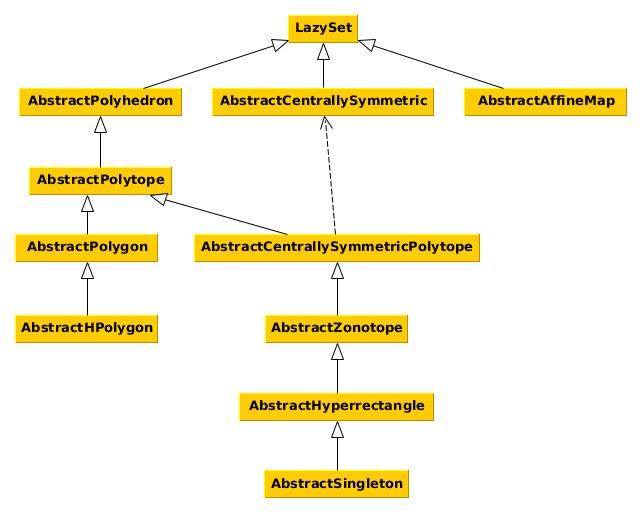

Overall there are 44 (convex) set types (26 concrete and 18 lazy) plus a few more non-convex set types.

In [ ]:
println("=== Concrete set types ===\n")
for S in subtypes(LazySet, true)
    if !isoperationtype(S)
        println(S)
    end
end
println("\n=== Lazy set types ===\n")
for S in subtypes(LazySet, true)
    if isoperationtype(S)
        println(S)
    end
end

`LazySets` requires that a set implements at least the `LazySet` interface (which needs an implementation for `dim` and `ρ`/`σ`). Because of that, one needs to use wrappers around structs from other packages. For example, `Interval` is a wrapper around `IntervalArithmetic.Interval` (which may cause confusion).

## Numerical tolerance

All `LazySets` set types are parametric in the numeric type and we try to preserve them in all operations. Known conversions to `Float64` happen when using an LP solver (typically when working with polytopes).

In [ ]:
X = BallInf([1//1, 1//1], 1//1)
Y = BallInf([2//1, 2//1], 1//1)
Z = intersection(X, Y)
dump(Z)

p(X, lab="X")
p!(Y, lab="Y")
p!(Z, lab="Z")

Operations with floating-point numbers may yield results that differ from the expected result due to precision problems. Generally one should avoid working with flat sets or very small/large values. The tolerance used in many `LazySets` operations can be controlled via the (unexported) functions `set_atol` (absolute tolerance), `set_rtol` (relative tolerance), and `set_ztol` (tolerance when comparing to zero).

In [ ]:
polygon() = VPolygon([[1.0, 1.0], [1.000000001, 1.0]])

# default relative tolerance
@show LazySets._rtol(Float64)

P1 = polygon()

@show vertices_list(P1)

# increase relative tolerance
LazySets.set_rtol(Float64, 1e-9)

P2 = polygon()

@show vertices_list(P2)

p(xlims=(0.9999999985, 1.000000002), ylims=(0.9999999985, 1.000000002))
p!(P1)
p!(P2)

# reset relative tolerance to default
LazySets.set_tolerance(Float64)

p!()

## Optional dependencies

`LazySets` uses [`Requires`](https://github.com/JuliaPackaging/Requires.jl) to add further functionality depending on whether some external packages are loaded. Here we quickly list the currently available packages. Some `LazySets` functionality prints instructive error messages when the corresponding packages are not loaded but are required by the code.

- [`Polyhedra`](https://github.com/JuliaPolyhedra/Polyhedra.jl): An interface for polyhedral computations and LP solvers. This is required for polyhedral computations in three or more dimensions.
- [`CDDLib`](https://github.com/JuliaPolyhedra/CDDLib.jl): A double-description method. For some operations we use this solver as the default, which is why a user may see this as a requirement. Alternatively, a custom solver can be passed to the operations.
- [`Optim`](https://github.com/JuliaNLSolvers/Optim.jl): Optimization package. Mainly used for computations with lazy intersections.
- [`Symbolics`](https://github.com/JuliaSymbolics/Symbolics.jl): Symbolic algebra. Used to conveniently construct polyhedral sets.
- [`StaticArrays`](https://github.com/JuliaArrays/StaticArrays.jl): Efficient, statically-sized arrays. Constructing sets with static arrays gives an additional boost in low dimensions.
- [`Distributions`](https://github.com/JuliaStats/Distributions.jl): Distributions used in probability theory. Allows to sample from sets in a non-uniform way.
- [`Makie`](https://github.com/JuliaPlots/Makie.jl): Plotting of 3D meshes.
- [`Expokit`](https://github.com/acroy/Expokit.jl): Lazy matrix exponential. Used for the `ExponentialMap` set type (linear map $\Phi X$ where $\Phi = e^M$).
- [`MiniQhull`](https://github.com/gridap/MiniQhull.jl): Delaunay triangulation.
- [`Javis`](https://github.com/Wikunia/Javis.jl): Smooth animations. We recently added some convenience functionality to ease the integration.

---

# Outlook

Some background information: `LazySets` started as a library for a reachability package for implementing an algorithm from a research project in 2017. Meanwhile the package consists of (at the time of writing) 119 source files with almost 26k LOC, 64 test files with over 5k LOC, and 66 markdown files with over 4k LOC, and is mainly being developed by [@mforets](https://github.com/mforets) and [@schillic](https://github.com/schillic), with contributions from 13 other people, including two JSoC/GSoC students. It was used in 12 research articles.

Set computations often do not allow for typical tricks you would expect to see in a Julia package. For instance, when working with generic polyhedra, there is very little structure, so most information cannot be statically inferred and needs to be computed from the concrete values (such as whether the polyhedron is empty). That is why there are so many set types: to bring in more structure for algorithms and dispatch. With that amount of possible type combinations we clearly do not have (and will never have) optimized code in all cases. Some code is already highly optimized, while other parts only use a naive fallback implementation (`LazySets` typically wants to give a slow result rather than none). For specific use cases one can often elicit speed-ups within several orders of magnitude by adding new methods.